In [5]:
# To get rid of those blocks of red warnings
import warnings
warnings.filterwarnings("ignore")

# Standard Imports
import numpy as np
from scipy import stats
import pandas as pd
from math import sqrt
import os
from sklearn.cluster import KMeans
import requests
import json

# Vis Imports
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from pandas.plotting import register_matplotlib_converters


# Modeling Imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import statsmodels.api as sm
from statsmodels.tsa.api import Holt


# Custom module imports
import acquire
import prepare

In [28]:
df = acquire.df_to_csv()
df.head(1)

,item_id,sale_amount,sale_date,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_state,store_zipcode
0,1,13.0,"Tue, 01 Jan 2013 00:00:00 GMT",1,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253


In [32]:
df.sale_date = df.sale_date.str.replace('00:00:00 GMT', '')
df.sale_date = df.sale_date.str.strip()
def prep_data(df):
    return df.assign(ds = pd.to_datetime(df.sale_date, format='%a, %d %b %Y')).\
            sort_values('ds').\
            assign(dollars_sold = df.sale_amount * df.item_price).\
            groupby(['ds'])[['dollars_sold']].sum().\
            reset_index().set_index('ds')

In [33]:
df = prep_data(df)
df = df[df.index != '2016-02-29']
df.head(2)


,dollars_sold
ds,
2013-01-01,73844.01
2013-01-02,73570.58


In [34]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

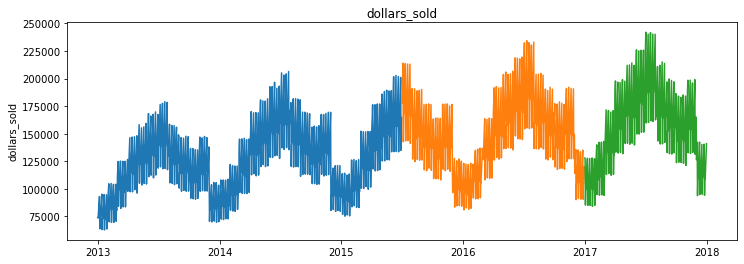

In [35]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [36]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

    # Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [38]:
dollars = train['dollars_sold'][-1:][0]

yhat_df = pd.DataFrame({'dollars_sold': [dollars]}, 
                       index = validate.index)

yhat_df.head(2)

,dollars_sold
ds,
2015-07-02,164573.2
2015-07-03,164573.2


In [39]:
dollars = round(train['dollars_sold'][-1:][0])

yhat_df = pd.DataFrame({'dollars_sold': [dollars]}, 
                       index = validate.index)

yhat_df.head(2)

,dollars_sold
ds,
2015-07-02,164573
2015-07-03,164573


dollars_sold -- RMSE: 35402


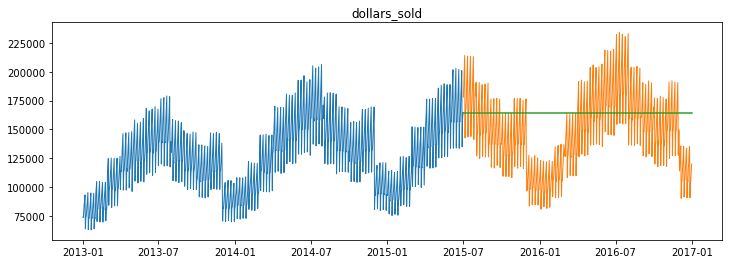

In [40]:
plot_and_eval(col)


In [41]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

In [42]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0


In [43]:
dollars = round(train['dollars_sold'].mean(), 2)


yhat_df = pd.DataFrame({'dollars_sold': [dollars],}, index = validate.index)

yhat_df.head(3)

,dollars_sold
ds,
2015-07-02,127517.85
2015-07-03,127517.85
2015-07-04,127517.85


dollars_sold -- RMSE: 39664


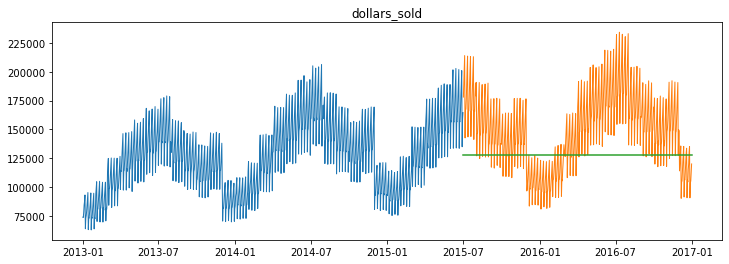

In [44]:
for col in train.columns:
    plot_and_eval(col)


In [45]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,simple_average,dollars_sold,39664.0


In [46]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 30

dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1])

# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'dollars_sold': [dollars],
                           }, index = validate.index)
yhat_df.head(2)

,dollars_sold
ds,
2015-07-02,168958
2015-07-03,168958


dollars_sold -- RMSE: 37378


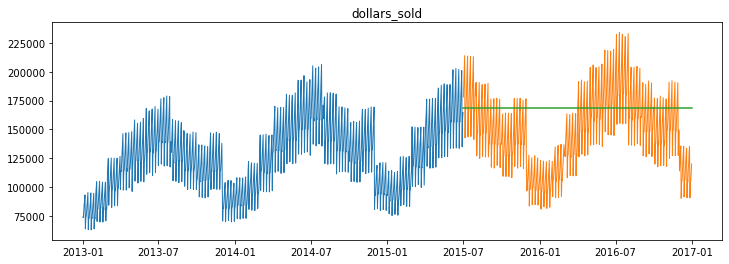

In [47]:
for col in train.columns:
    plot_and_eval(col)

In [48]:
for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,simple_average,dollars_sold,39664.0
2,30d moving average,dollars_sold,37378.0


In [52]:
periods = [1, 4, 12, 26, 52, 104]

for p in periods:
    dollars = round(train['dollars_sold'].rolling(p).mean().iloc[-1])

    yhat_df = pd.DataFrame({'dollars_sold': [dollars]}, index = validate.index)

    model_type = str(p) + 'd moving average'
    
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'dollars_sold'
                            )

In [53]:
eval_df


,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,simple_average,dollars_sold,39664.0
2,30d moving average,dollars_sold,37378.0
3,1d moving average,dollars_sold,35402.0
4,4d moving average,dollars_sold,35515.0
5,12d moving average,dollars_sold,37644.0
6,26d moving average,dollars_sold,37640.0
7,52d moving average,dollars_sold,35322.0
8,104d moving average,dollars_sold,32803.0


In [54]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[(eval_df.rmse == min_rmse_dollars_sold)]

,model_type,target_var,rmse
8,104d moving average,dollars_sold,32803.0


dollars_sold 



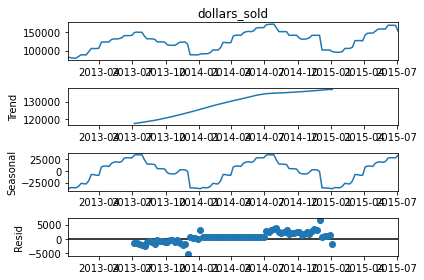

In [55]:
for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
    plt.show()

In [56]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

dollars_sold -- RMSE: 34700


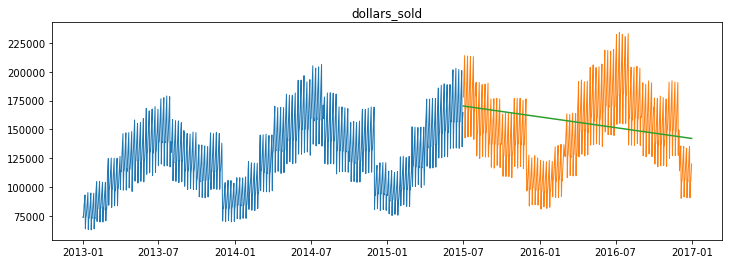

In [57]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [58]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,simple_average,dollars_sold,39664.0
2,30d moving average,dollars_sold,37378.0
3,1d moving average,dollars_sold,35402.0
4,4d moving average,dollars_sold,35515.0
5,12d moving average,dollars_sold,37644.0
6,26d moving average,dollars_sold,37640.0
7,52d moving average,dollars_sold,35322.0
8,104d moving average,dollars_sold,32803.0
9,Holts,dollars_sold,34700.0


In [59]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

In [60]:
yhat_df = train['2015'] + train.diff(365).mean()
pd.concat([yhat_df.head(1), validate.head(1)])

,dollars_sold
ds,
2015-01-01,104337.620493
2016-01-01,107875.260000


In [61]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)

365

dollars_sold -- RMSE: 28087


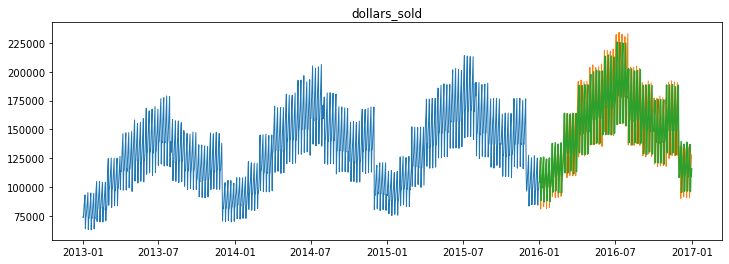

In [62]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

In [63]:
eval_df


,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,simple_average,dollars_sold,39664.0
2,30d moving average,dollars_sold,37378.0
3,1d moving average,dollars_sold,35402.0
4,4d moving average,dollars_sold,35515.0
5,12d moving average,dollars_sold,37644.0
6,26d moving average,dollars_sold,37640.0
7,52d moving average,dollars_sold,35322.0
8,104d moving average,dollars_sold,32803.0
9,Holts,dollars_sold,34700.0


In [64]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[(eval_df.rmse == min_rmse_dollars_sold)]

,model_type,target_var,rmse
10,previous year,dollars_sold,28087.0


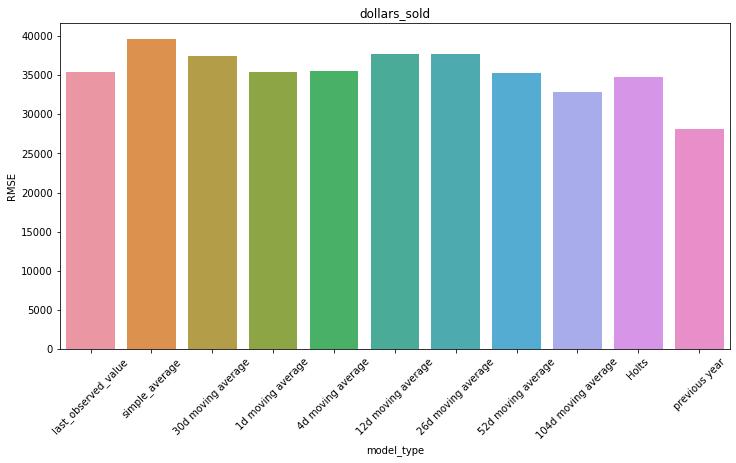

In [65]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

In [66]:
yhat_df = validate + train.diff(365).mean()
yhat_df.index = test.index

In [67]:
rmse_dollars = round(sqrt(mean_squared_error(test['dollars_sold'], yhat_df['dollars_sold'])), 0)


In [72]:
# Plot and evaluate train, validate, and test
def plot_and_eval_test(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5, color="red")
    plt.title(target_var)
    plt.legend()
    plt.show()

rmse - dollars_sold:  27115.0


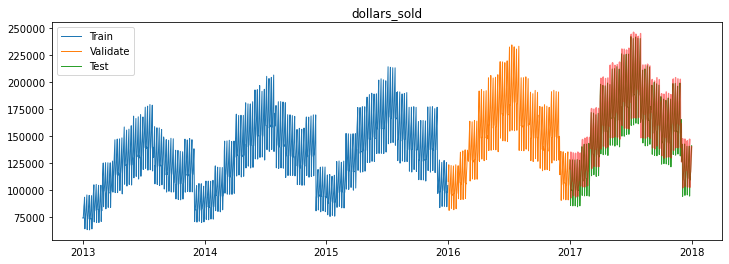

In [73]:
print("rmse - dollars_sold: ", rmse_dollars)
for col in train.columns:
    plot_and_eval_test(col)